## 0. Setup

In [1]:
## Utils to read data

from enum import Enum
from pathlib import Path
import sys



DATA_PATH_PREFIX = Path.cwd().parent / "data/SAMD21_Fan_Demo-"

# go to project root
sys.path.append(str(Path.cwd().parent.parent))

class DataType(Enum):
    Normal = 1
    Blocked = 2
    Interference = 3
    OFF = 4


def get_data_path(datatype: DataType, index: int):

    if datatype == DataType.Interference:
        strcode = "Blade Interference"
    
    elif datatype == DataType.Normal:
        strcode = "Fan ON"
    
    elif datatype == DataType.Blocked:
        strcode = "Blocked Flow"
    
    elif datatype == DataType.OFF:
        strcode = "Fan OFF"
    
    postfix = strcode + f"_{index:03d}" + ".csv"
    return str(DATA_PATH_PREFIX) + postfix



## 1. Prepare training data

In [2]:
from architecture.classification.operating_types import OperatingCondition
from utils.utils import prepare_training_data

# prepare_training_data expects Mapping[int, list[str]], so convert Path objects to str
NORMAL_FILES = [str(get_data_path(DataType.Normal, i)) for i in range(1, 5)]
FAULTY_FILES = [str(get_data_path(DataType.Blocked, i)) for i in range(1, 4)]


training_data = {
    OperatingCondition.NORMAL.value: NORMAL_FILES,
    OperatingCondition.BLOCKED_AIRFLOW.value: FAULTY_FILES
}

data = prepare_training_data(training_data, True)

## 2. Preprocessing (TODO)

## 3. Embedding

In [3]:
from architecture.classification.embedder import MLEmbedder1

embedder = MLEmbedder1()
embeddings = embedder.embed(data)
embeddings[0]



array([ 2.10955665e+03,  2.43961198e+01,  2.10969771e+03,  1.14221275e+02,
        1.03127283e+00,  3.29945582e-01, -4.12613166e-01,  3.62433323e+02,
        4.83584311e+02,  8.84518073e+03,  7.49472872e-01,  6.32812500e+01,
        6.71188332e-01,  2.42434173e+02,  4.71057459e-01,  4.59770257e+00,
        8.93348516e-03,  4.20285347e+00,  8.16628057e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.93668902e+02,  3.63008066e-02,  4.42968750e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  8.20324309e-02,  9.16913428e-01,  1.05414123e-03,
        4.93827160e-02,  6.32812500e+01,  1.01250000e+01])

## 3.1 Optional PCA - observe how good are the embeddings

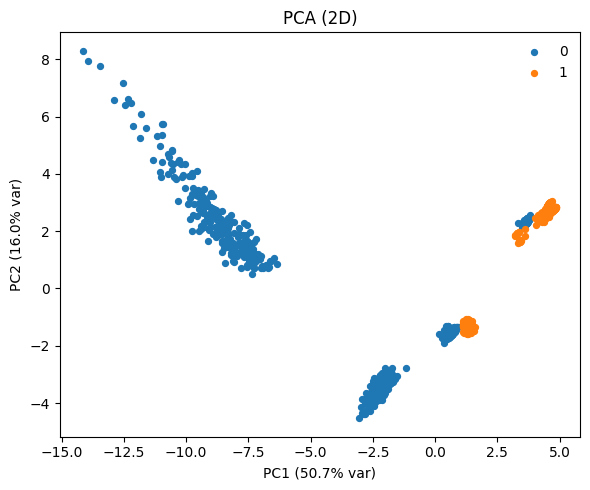

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def plot_pca_2d(embeddings, labels):
    emb_df = pd.DataFrame(embeddings)
    X = StandardScaler().fit_transform(emb_df)
    y = labels


    pca = PCA(n_components=2)
    Z = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    if y is None:
        plt.scatter(Z[:,0], Z[:,1], s=18)
    else:
        for cls in np.unique(y):
            m = (y == cls)
            plt.scatter(Z[m,0], Z[m,1], s=18, label=str(cls))
        plt.legend(frameon=False)

    evr = pca.explained_variance_ratio_
    plt.xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
    plt.title("PCA (2D)")
    plt.tight_layout()
    plt.show()


labels = [d.label for d in data]

plot_pca_2d(embeddings, labels)


## 4. Training

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from joblib import dump, load
import os
from pathlib import Path

# Convert list of dicts to DataFrame
X = embeddings
y = [d.label for d in data]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


# Train classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Number of test packets: ", len(y_test))
print("Accuracy: ", sum(y_test == y_pred) / len(y_test))

os.makedirs("weights", exist_ok=True)
dump(clf, "weights/rf_model.joblib")


[[383   0]
 [  0 281]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       383
           1       1.00      1.00      1.00       281

    accuracy                           1.00       664
   macro avg       1.00      1.00      1.00       664
weighted avg       1.00      1.00      1.00       664

Number of test packets:  664
Accuracy:  1.0


['weights/rf_model.joblib']

## 5. Extra test
Seems odd that the accuracy is too good, let me try on dataset that was never fed to the model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       237
           1       1.00      1.00      1.00       239

    accuracy                           1.00       476
   macro avg       1.00      1.00      1.00       476
weighted avg       1.00      1.00      1.00       476

Number of test packets:  476
Accuracy:  1.0


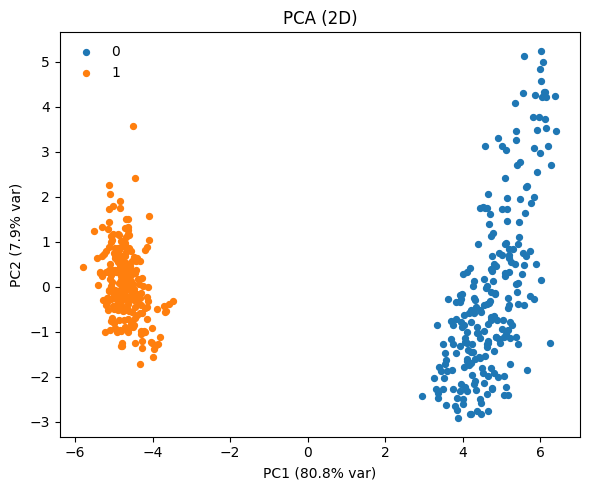

In [6]:
NORMAL_FILES_2 = [str(get_data_path(DataType.Normal, i)) for i in range(5, 6)]
FAULTY_FILES_2 = [str(get_data_path(DataType.Blocked, i)) for i in range(4, 5)]
raw_data = {
    OperatingCondition.NORMAL.value: NORMAL_FILES_2,
    OperatingCondition.BLOCKED_AIRFLOW.value: FAULTY_FILES_2
}

data = prepare_training_data(raw_data, True)
X = embedder.embed(data)
y_true = np.array([d.label for d in data])

clf_loaded: RandomForestClassifier = load("weights/rf_model.joblib")
y_pred = clf_loaded.predict(X)

print(classification_report(y_true, y_pred))
print("Number of test packets: ", len(y_true))
print("Accuracy: ", sum(y_true == y_pred) / len(y_true))

plot_pca_2d(X, y_true)


## 6. Exmple of using ClassificationPipeline for inference

Q: Why do we need such Wrapper?  
Ans: It might seem "stupid" for some, but treat it as an investment. Such structuring reduces later cost of development.  
Imagine when we want to integrate with the hardware for demo, it's easier to not think much and just assemble the pipeline  
and then call pipeline.infer() to predict if a particular input is "normal" or "blocked_airflow"



In [15]:
from architecture.classification.pipeline import ClassificationPipeline
from architecture.classification.embedder import MLEmbedder1
from architecture.classification.preprocessor import DummyPreprocessor
from architecture.classification.inferrer import SklearnMLInferrer


# 1. load model
model: RandomForestClassifier = load("weights/rf_model.joblib")

# 2. load pipeline
pipeline = ClassificationPipeline(
    preprocessor=DummyPreprocessor(),
    embedder=MLEmbedder1(),
    inferrer=SklearnMLInferrer(model=model)
)

# 3. get data ready
NORMAL_FILES_2 = [str(get_data_path(DataType.Normal, i)) for i in range(5, 6)]
FAULTY_FILES_2 = [str(get_data_path(DataType.Blocked, i)) for i in range(4, 5)]
raw_data = {
    OperatingCondition.NORMAL.value: NORMAL_FILES_2,
    OperatingCondition.BLOCKED_AIRFLOW.value: FAULTY_FILES_2
}
data = prepare_training_data(raw_data, True)
y_true = np.array([d.label for d in data])



Note that on deployment, it is highly likely we only declare pipeline once, and reuse it over and over again  
this reduces the cost. That's why I split the code here (to measure performance more reliably)

NB: My laptop takes about 3 ms to infer a packet with WINDOW_LENGTH = 100, Sampling_rate = 400 Hz  
So it takes 3ms to process 0.25 s of data for now

In [25]:
import time

start = time.perf_counter()
# 4. run inference
y_pred = pipeline.predict(data)

# 5. Get accuracy
print(classification_report(y_true, y_pred))
print("Number of test packets: ", len(data))
print("Accuracy: ", sum(y_true == y_pred) / len(y_true))

end = time.perf_counter()

interval = end - start 
time_per_packet = (interval * 1000) / len(data)
print(f"Pipeline inference time: {time_per_packet:.2f} ms per packet")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       237
           1       1.00      1.00      1.00       239

    accuracy                           1.00       476
   macro avg       1.00      1.00      1.00       476
weighted avg       1.00      1.00      1.00       476

Number of test packets:  476
Accuracy:  1.0
Pipeline inference time: 2.96 ms per packet
